In order to work, this notebook _must_ be opened from anaconda prompt run in administrator mode. Navigate to the parent folder, activate conda env 'testenv', and open jupyter with 'jupyter notebook'

# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [69]:
# import statements

# general
import numpy as np
import random
from glob import glob
import cv2
from tqdm import tqdm
from extract_bottleneck_features import *
import os

# keras
from keras import regularizers
from keras import optimizers
from keras import Model

from keras.utils import np_utils

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications import xception

from keras.preprocessing import image  
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras.callbacks import ModelCheckpoint
from keras.callbacks import History

# sklearn
from sklearn.datasets import load_files

# image processing
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13613321056449932122
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18090036786881134405
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# tensorflow local GPU configuration
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']))#, 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
# the [20:-1] portion simply removes the filepath and folder number
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [ ]:
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [ ]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[5])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [ ]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

The algorithm finds human faces in 99% of the human subset and 12% of the dog subset

In [ ]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_found = 0
dogman_found = 0
for img_path in human_files_short:
    if face_detector(img_path):
        human_found += 1

for img_path in dog_files_short:
    if face_detector(img_path):
        dogman_found += 1
        
print(f'Found {human_found} faces in the human dataset')
print(f'Found {dogman_found} faces in the dog dataset')


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [ ]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [58]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, target_size=(150, 150)):
    # loads RGB image as PIL.Image.Image type
    # 299 is for xception, 224 for the other models
    img = image.load_img(img_path, target_size=target_size)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, target_size = (150, 150)):
    list_of_tensors = [path_to_tensor(img_path, target_size) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [ ]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [ ]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

1% of the photos in the human dataset have a detected dog; 100% of the photos in the dog dataset have a detected dog.

In [ ]:
# Following block is neccessary to utilize GPU
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_detected_dog_short = 0
dog_detected_human_short = 0

for img_path in human_files_short:
    if dog_detector(img_path):
        dog_detected_human_short += 1

for img_path in dog_files_short:
    if dog_detector(img_path):
        dog_detected_dog_short += 1
        
print(f'Found {dog_detected_human_short} dogs in the human dataset')
print(f'Found {dog_detected_dog_short} dogs in the dog dataset')

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_ !), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:06<00:00, 133.98it/s]


In [ ]:
train_tensors[0]

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [ ]:
train_tensors[0].shape

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

# Define your architecture.
model.add(Conv2D(16, kernel_size=2, activation='relu', input_shape=(224,224,3))) # activation nonlinearity typically performed before pooling
model.add(MaxPooling2D()) # defaults to pool_size = (2,2), stride = None = pool_size
model.add(Conv2D(32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

### Compile the Model

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
from keras.callbacks import ModelCheckpoint  

# specify the number of epochs that you would like to use to train the model.

epochs = 3

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [ ]:
train_VGG16.shape

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

### Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [ ]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### Predict Dog Breed with the Model

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [ ]:
# Obtain bottleneck features from another pre-trained CNN.

# function to test a network
networks = ['VGG19', 'ResNet50', 'InceptionV3', 'Xception']

def xfer_net_tester(network_name):
    print(f'testing network: {network}')
    
    # get bottleneck features
    print('\tgetting bottleneck features...')
    bottleneck_features = np.load(f'bottleneck_features/Dog{network}Data.npz')
    
    # translate read-in features into test-train-validate
    train_bottle = bottleneck_features['train']
    valid_bottle = bottleneck_features['valid']
    test_bottle = bottleneck_features['test']
    
    # compile our own output sigmoids
    print('\tcompiling custom output nodes...')
    xfer_model = Sequential()
    xfer_model.add(GlobalAveragePooling2D(input_shape=train_bottle.shape[1:]))
    xfer_model.add(Dense(133, activation='softmax'))

    #xfer_model.summary()
    xfer_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    print('\ttraining model...')
    checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.best.{network}.hdf5', 
                               verbose=1, save_best_only=True)

    xfer_model.fit(train_bottle, train_targets, 
          validation_data=(valid_bottle, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)
    
    # load best model
    print('\tloading best model...')
    xfer_model.load_weights(f'saved_models/weights.best.{network}.hdf5')
    
    # get index of predicted dog breed for each image in test set
    print('\ttesting model...')
    xfer_predictions = [np.argmax(xfer_model.predict(np.expand_dims(feature, axis=0))) for feature in test_bottle]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(xfer_predictions)==np.argmax(test_targets, axis=1))/len(xfer_predictions)
    
    print('{} Test accuracy: {:.4f}'.format(network, test_accuracy))
    return test_accuracy
    
n_accs = []
for network in networks:
    n_acc = xfer_net_tester(network)
    n_accs.append((network, n_acc))

print(n_accs)
            

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [ ]:
# Define your architecture.
# it appears that the Xception model performs the best

from keras.callbacks import History 
history = History()

net = 'Xception' # too much entropic capacity - memorized models with its parameters
#net = 'ResNet50'
#net = 'VGG19'
#net = 'InceptionV3'

# get bottleneck features
bottleneck_features = np.load(f'bottleneck_features/Dog{net}Data.npz')

# translate read-in features into test-train-validate
train_bottle = bottleneck_features['train']
valid_bottle = bottleneck_features['valid']
test_bottle = bottleneck_features['test']

In [ ]:
# define custom model architecture 1
custom_model = Sequential()
custom_model.add(GlobalAveragePooling2D(input_shape=train_bottle.shape[1:]))
custom_model.add(Dense(133, activation='softmax'))

custom_model.summary()

In [ ]:
train_bottle.shape[1:]

In [ ]:
# define custom model architecture 2
from keras import regularizers

custom_model = Sequential()

custom_model.add(GlobalAveragePooling2D(input_shape = train_bottle.shape[1:]))
custom_model.add(Dense(512,
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(0.01)))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(256,
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(0.02)))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(133, activation='softmax'))

custom_model.summary()

### (IMPLEMENTATION) Compile the Model

In [ ]:
# Compile the model.
from keras import optimizers

#custom_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
custom_model.compile(loss='categorical_crossentropy',
                     optimizer=optimizers.SGD(lr=1.5e-4, momentum=0.9),
                     metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement.

<font color='green'> I augment the training data on my own in the next section <font>

In [ ]:
%%time

# Train the model.

print('training model...')
checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.best.{net}.hdf5', 
                           verbose=1, save_best_only=True)

custom_model.fit(train_bottle, train_targets, 
      validation_data=(valid_bottle, valid_targets),
      epochs=250, batch_size=20, callbacks=[checkpointer, history], verbose=2)

In [ ]:
print(history.history.keys())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(len(history.history['acc']))

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)

sns.lineplot(x = epochs, y=history.history['acc'], ax=ax1, label = 'acc')
sns.lineplot(x = epochs, y=history.history['val_acc'], ax=ax1, label = 'val_acc')
ax1.set_ylim(0, 1.05);
ax1.set_title('Rolling accuracy');

sns.lineplot(x = epochs, y=history.history['loss'], ax=ax2, label = 'loss')
sns.lineplot(x = epochs, y=history.history['val_loss'], ax=ax2, label = 'val_loss')
ax2.set_title('Rolling loss');

fig.suptitle(f'{net} training metrics', fontsize = 16);
max_val_acc = max(history.history['val_acc'])
print(f'This model achieved a max validation accuracy of {max_val_acc}')

__note: the use of dropout artificially lowers the training accuracy__

## Custom model layer 1: global average pooling, dense_1; RMSProp optim
### Xception
accuracy and loss was static for both validation and training

### ResNet50
accuracy quickly jumped to near 100 while validation accuracy rose very slightly between .79-.81. Train loss went quickly to 0 while validation loss rose slowly to .8

### VGG19
Over 50 epochs, accuracy climbed from .7 - .8, val acc climbed for the first 30 epochs slightly but stagnated. Loss and val loss both dropped steadily to 3.5 and 5 respectively.

## Custom model layer 2: Flatten, dense_1, dropout, dense_2; SGD optim
### ResNet50
Over 250 epochs, val accuracy and accuracy met at .8 around 90 epochs, then accuracy continued to grow while val accuracy stagnated. Loss steadily dropped...

Trying increasing dropout... same results, except accuracy took a full 250 epochs to hit .8

Trying l2 regularization... same results more or less

Trying l1 regularization... failed to learn

### VGG19
Over 250 epochs, accuracy slowly rose to about .7, val accuracy stagnated at about .5. Loss steadily dropped, val loss dropped with diminishing returns

### Xception
25 million parameters training, with full dropout and l2 .01

Over 250 epochs, accuracy continued to rise while validation accuracy capped at about 85% after just 30 or so epochs.



### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
# Load the model weights with the best validation loss.
custom_model.load_weights(f'saved_models/weights.best.{net}.hdf5')

# get index of predicted dog breed for each image in test set
custom_predictions = [np.argmax(custom_model.predict(np.expand_dims(feature, axis=0))) for feature in test_bottle]

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
# Calculate classification accuracy on the test dataset.
test_accuracy = 100*np.sum(np.array(custom_predictions)==np.argmax(test_targets, axis=1))/len(custom_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# Custom training data augmentation
## From the ground-up bottlenecking and modeling

In [ ]:
import os
os.listdir('dogImages/train/001.Affenpinscher')

In [11]:
# try to match the output of the generator for an un-augmented image to what we expect from the bottleneck features
print('generating model')
base_xception = xception.Xception(weights='imagenet')
print('loading bottlenecks')
bottleneck_features = np.load(f'bottleneck_features/DogXceptionData.npz')
    
train_bottle = bottleneck_features['train']
valid_bottle = bottleneck_features['valid']
test_bottle = bottleneck_features['test']

generating model
loading bottlenecks


In [6]:
#np.expand_dims(train_tensors[0], axis=0).shape
# train_tensors is generated by path_to_tensor('path/img.jpg').astype(float)/255

tensor_input = np.expand_dims(np.copy(train_tensors[0]), axis=0)

x = xception.Xception(weights='imagenet', include_top=False).predict(xception.preprocess_input(tensor_input))

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
tensor_input[0].shape

(299, 299, 3)

In [17]:
train_bottle[0].shape

(7, 7, 2048)

In [ ]:
type(np.squeeze(x, axis=0)[0][0][0])

In [18]:
x[0].shape

(10, 10, 2048)

In [ ]:
train_bottle.shape # (6680, 7, 7, 2048)

train_bottle[0].shape # (7, 7, 2048) --- this should be xception output for the first image

sanity_datagen = ImageDataGenerator(
    preprocessing_function = xception.preprocess_input,
    #rotation_range = 40,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    rescale = 1./255,
    #shear_range = 0.2,
    #zoom_range = 0.2,
    #horizontal_flip = True,
    #fill_mode = 'nearest'
    )

batch_size = 8

# xception expects 299x299 images
sanity_generator = sanity_datagen.flow_from_directory(
    'dogImages/test',
    target_size = (299, 299),
    batch_size = batch_size,
    class_mode = 'categorical')



test_xception = Model(input = base_xception.input, output=base_xception.get_layer('avg_pool').output)

x = test_xception.predict_generator(sanity_generator, steps = 836 // batch_size)

In [ ]:
next(sanity_generator)[0].shape
x.shape

In [ ]:
test_xception.layers

In [ ]:
##############################################################################################################
##############################################################################################################

In [21]:
# training image augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.callbacks import History 
from keras.applications import xception

batch_size = 16

# this is the augmentation configuration I will use for training
train_datagen = ImageDataGenerator(
    preprocessing_function = xception.preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
    )

# This is the augmentation configuration I will use for testing/validation... just a rescale
test_datagen = ImageDataGenerator(
    preprocessing_function = xception.preprocess_input,
    rescale=1./255
    )

# This is the generator which will read pictures found in my training subset
train_generator = train_datagen.flow_from_directory(
    'dogImages/train',
    target_size = (299, 299),
    batch_size = batch_size,
    class_mode = 'categorical')

# This is the generator for calidation data
validation_generator = test_datagen.flow_from_directory(
    'dogImages/valid',
    target_size = (299, 299),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [81]:
next(validation_generator)[0][0]

array([[[-0.00389081, -0.00389081, -0.00389081],
        [-0.00392157, -0.00392157, -0.00392157],
        [-0.00392157, -0.00392157, -0.00392157],
        ...,
        [-0.00379854, -0.00318339, -0.00355248],
        [-0.00376778, -0.00315263, -0.00352172],
        [-0.0038293 , -0.00321415, -0.00358324]],

       [[-0.00389081, -0.00389081, -0.00389081],
        [-0.00392157, -0.00392157, -0.00392157],
        [-0.00392157, -0.00392157, -0.00392157],
        ...,
        [-0.00349097, -0.00287582, -0.00324491],
        [-0.00346021, -0.00284506, -0.00321415],
        [-0.00370627, -0.00309112, -0.00346021]],

       [[-0.00392157, -0.00392157, -0.00392157],
        [-0.00392157, -0.00392157, -0.00392157],
        [-0.00386005, -0.00386005, -0.00386005],
        ...,
        [-0.00349097, -0.00293733, -0.00330642],
        [-0.00346021, -0.00290657, -0.00327566],
        [-0.00379854, -0.00324491, -0.00361399]],

       ...,

       [[-0.00019992, -0.0005075 , -0.00127643],
        [-0

In [50]:
ground_up_model = Sequential()

print('loading Xception base...')
Xception_cnn_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

print('building custom dense addon...')
model = Sequential()

model.add(GlobalAveragePooling2D(input_shape = Xception_cnn_model.output_shape[1:])) # the [1:] is necessary to allow for automatic batch dimension to be added by keras

model.add(Dense(512,
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(256,
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(133, activation='softmax'))

model.summary()

print('assembling composite model...')
ground_up_model.add(Xception_cnn_model)
ground_up_model.add(model)

for layer in ground_up_model.layers[0].layers:
    layer.trainable = False


print('compiling composite model...')

# ground_up_1
# ground_up_model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.SGD(lr=1.0e-4, momentum=0.9),
#              metrics=['accuracy'])

ground_up_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
print('done.')

loading Xception base...
building custom dense addon...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 133)               34181     
Total params: 1,214,597
Trainable params: 1,214,597
Non-trainable params: 0
__________

In [ ]:
# only run if resuming an old model training
print('loading last iteration...')
ground_up_model.load_weights(f'saved_models/weights.best.groundup_1.hdf5')
print('done')

In [ ]:
ground_up_model.history.history

In [51]:
history = History()
checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.best.groundup_5.hdf5', 
                           verbose=1, save_best_only=True)

In [52]:
%%time
ground_up_model.fit_generator(
    train_generator,
    steps_per_epoch = 6680 // batch_size,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = 835 // batch_size,
    callbacks = [checkpointer, history],
    verbose=2)

Epoch 1/50
 - 241s - loss: 4.9473 - acc: 0.4134 - val_loss: 2.4836 - val_acc: 0.7375

Epoch 00001: val_loss improved from inf to 2.48364, saving model to saved_models/weights.best.groundup_5.hdf5
Epoch 2/50
 - 227s - loss: 2.6810 - acc: 0.6025 - val_loss: 2.1414 - val_acc: 0.7143

Epoch 00002: val_loss improved from 2.48364 to 2.14144, saving model to saved_models/weights.best.groundup_5.hdf5
Epoch 3/50
 - 229s - loss: 2.3994 - acc: 0.6346 - val_loss: 1.9457 - val_acc: 0.7411

Epoch 00003: val_loss improved from 2.14144 to 1.94570, saving model to saved_models/weights.best.groundup_5.hdf5
Epoch 4/50
 - 227s - loss: 2.2419 - acc: 0.6452 - val_loss: 1.8560 - val_acc: 0.7558

Epoch 00004: val_loss improved from 1.94570 to 1.85595, saving model to saved_models/weights.best.groundup_5.hdf5
Epoch 5/50
 - 226s - loss: 2.1597 - acc: 0.6509 - val_loss: 1.7477 - val_acc: 0.7680

Epoch 00005: val_loss improved from 1.85595 to 1.74771, saving model to saved_models/weights.best.groundup_5.hdf5
Epoc

This model achieved a max validation accuracy of 0.8351648352376125


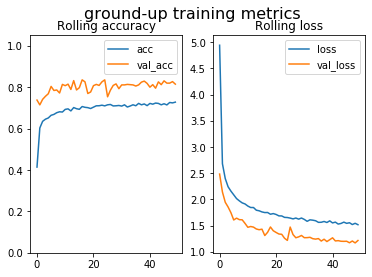

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(len(history.history['acc']))

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)

sns.lineplot(x = epochs, y=history.history['acc'], ax=ax1, label = 'acc')
sns.lineplot(x = epochs, y=history.history['val_acc'], ax=ax1, label = 'val_acc')
ax1.set_ylim(0, 1.05);
ax1.set_title('Rolling accuracy');

sns.lineplot(x = epochs, y=history.history['loss'], ax=ax2, label = 'loss')
sns.lineplot(x = epochs, y=history.history['val_loss'], ax=ax2, label = 'val_loss')
#ax[1].set_ylim(.5, 1.05);
ax2.set_title('Rolling loss');

fig.suptitle(f'ground-up training metrics', fontsize = 16);
max_val_acc = max(history.history['val_acc'])

print(f'This model achieved a max validation accuracy of {max_val_acc}')

In [54]:
plt.savefig('ground_up_5_training.png')

<Figure size 432x288 with 0 Axes>

ground_up_1 achieved 81.4% val accuracy after 109 epochs, and it looks like it was still possibly going up!

changing to adam for ground_up_2... 84.5% accuracy, very quickly (98% max at ~50 epochs)

changing to reduce dropout from (.5, .5) to (.4, .4) for ground_up_3... reached max accuracy of 83.9% in 20 epochs

changing to try l1 regularization for ground_up_3... did shitty

adding layer for ground_up_4... did shitty

changing dropout to (.2, .2) for ground_up_5

In [82]:
test_generator = test_datagen.flow_from_directory(
    'dogImages/test',
    target_size = (299, 299),
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = ground_up_model.predict_generator(test_generator,steps = nb_samples)

Found 836 images belonging to 133 classes.


In [106]:
prediction_labels = np.array([np.argmax(x) for x in predict])
test_accuracy = np.sum(test_generator.labels == prediction_labels)/len(test_generator.labels) * 100

print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.9378%


In [179]:
def final_predict_xception(final_model, img_path, topk = 3):
    
    # obtain predicted vector
    #tensor = path_to_tensor(img_path, (299, 299)).astype('float32')/255
    img = load_img(img_path, target_size = (299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = xception.preprocess_input(x)
    predicted_vector = final_model.predict(x)
    
    # return dog breed that is predicted by the model
    print(np.argmax(predicted_vector))
    results = sorted(enumerate(predicted_vector[0]), reverse=True, key=lambda x:x[1])
    classes_ind = [x[0] for x in results]
    classes = [dog_names[x] for x in classes_ind][:topk]
    probs = [x[1] for x in results][:topk]
    
    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    img = mpimg.imread(img_path)
    ax1.imshow(img)
    
    ind = np.arange(len(classes))
    ax2.bar(ind, probs, align='center', alpha = .75)
    ax2.set_xticks(ind)
    ax2.set_xticklabels(classes, rotation=90)
    
    return predicted_vector, x

67
Newfoundland


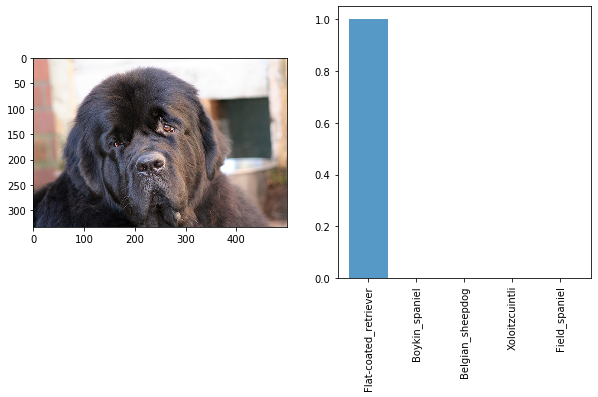

In [180]:
src = 'C:/Users/Jesse/Documents/PyData/DSND_t2_capstone/dog-project/dogImages/test'
folder = random.choice(os.listdir(src))
file = random.choice(os.listdir(src+'/'+folder))
fullpath = '/'.join([src, folder, file])

p_vec, xtens = final_predict_xception(ground_up_model, fullpath, topk = 5)

print(fullpath.split('/')[-2].split('.')[-1])

In [182]:
xtens

array([[[[ 0.58431375,  0.2941177 ,  0.24705887],
         [ 0.5921569 ,  0.28627455,  0.24705887],
         [ 0.6       ,  0.27843142,  0.24705887],
         ...,
         [ 0.67058825,  0.48235297,  0.13725495],
         [ 0.8039216 ,  0.60784316,  0.28627455],
         [ 1.        ,  0.79607844,  0.52156866]],

        [[ 0.6156863 ,  0.2941177 ,  0.24705887],
         [ 0.62352943,  0.28627455,  0.23921573],
         [ 0.6313726 ,  0.2941177 ,  0.24705887],
         ...,
         [ 0.6627451 ,  0.47450984,  0.12941182],
         [ 0.8039216 ,  0.58431375,  0.27058828],
         [ 1.        ,  0.7882353 ,  0.52156866]],

        [[ 0.654902  ,  0.28627455,  0.22352946],
         [ 0.64705884,  0.27843142,  0.21568632],
         [ 0.654902  ,  0.27058828,  0.2313726 ],
         ...,
         [ 0.67058825,  0.45882356,  0.12156868],
         [ 0.8039216 ,  0.58431375,  0.27058828],
         [ 1.        ,  0.78039217,  0.5137255 ]],

        ...,

        [[-0.8901961 , -0.85882354, -0

In [167]:
sorted(enumerate(predicted_vector[0]), reverse=True, key=lambda x:x[1])

[(67, 0.9988299),
 (34, 0.0011695654),
 (0, 4.913485e-07),
 (54, 1.6599039e-08),
 (130, 4.5887196e-09),
 (20, 3.7358344e-10),
 (65, 4.0950563e-12),
 (17, 2.597392e-12),
 (55, 1.1005141e-12),
 (8, 7.1814527e-13),
 (111, 3.0765803e-13),
 (73, 3.238007e-14),
 (72, 8.538562e-15),
 (46, 2.6453654e-15),
 (95, 1.3540873e-15),
 (10, 5.5958787e-16),
 (60, 3.0207776e-16),
 (86, 1.6682575e-16),
 (66, 3.6656542e-17),
 (131, 1.2142208e-17),
 (83, 1.8415962e-18),
 (120, 8.3280637e-19),
 (92, 8.1418193e-19),
 (42, 7.780664e-19),
 (127, 5.1538403e-19),
 (85, 9.612231e-20),
 (69, 5.8858e-20),
 (28, 3.4854654e-20),
 (75, 1.5680226e-20),
 (19, 1.004582e-20),
 (25, 4.7697924e-21),
 (124, 3.7448954e-21),
 (105, 1.7394334e-21),
 (119, 6.9883267e-22),
 (1, 1.6925661e-22),
 (43, 1.6755166e-22),
 (74, 1.3654786e-22),
 (96, 8.5748896e-23),
 (80, 2.3449687e-23),
 (48, 1.8839407e-23),
 (11, 1.20763916e-23),
 (41, 9.9021394e-24),
 (122, 3.2051908e-24),
 (88, 1.7366394e-24),
 (37, 6.407215e-25),
 (47, 3.8244637e-25

In [168]:
dog_names

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog',
 'Australian_cattle_dog',
 'Australian_shepherd',
 'Australian_terrier',
 'Basenji',
 'Basset_hound',
 'Beagle',
 'Bearded_collie',
 'Beauceron',
 'Bedlington_terrier',
 'Belgian_malinois',
 'Belgian_sheepdog',
 'Belgian_tervuren',
 'Bernese_mountain_dog',
 'Bichon_frise',
 'Black_and_tan_coonhound',
 'Black_russian_terrier',
 'Bloodhound',
 'Bluetick_coonhound',
 'Border_collie',
 'Border_terrier',
 'Borzoi',
 'Boston_terrier',
 'Bouvier_des_flandres',
 'Boxer',
 'Boykin_spaniel',
 'Briard',
 'Brittany',
 'Brussels_griffon',
 'Bull_terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn_terrier',
 'Canaan_dog',
 'Cane_corso',
 'Cardigan_welsh_corgi',
 'Cavalier_king_charles_spaniel',
 'Chesapeake_bay_retriever',
 'Chihuahua',
 'Chinese_crested',
 'Chinese_shar-pei',
 'Chow_cho

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [ ]:
custom_model.load_weights(f'saved_models/weights.best.{net}.hdf5')

In [ ]:
# Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

print('building model')
final_model = Sequential()

ResNet50_cnn_model = ResNet50(weights='imagenet', include_top=False)
custom_model.load_weights(f'saved_models/weights.best.{net}.hdf5')

final_model.add(ResNet50_cnn_model)
final_model.add(custom_model)

final_model.summary()
final_model.save('saved_models/final_model.h5')

In [ ]:
%matplotlib inline
from keras.applications.resnet50 import preprocess_input

def final_predict(img_path, topk = 3):
    
    # obtain predicted vector
    
    predicted_vector = final_model.predict(preprocess_input(path_to_tensor(img_path)))
    
    # return dog breed that is predicted by the model
    # print(dog_names[np.argmax(predicted_vector)])
    results = sorted(enumerate(predicted_vector[0]), reverse=True, key=lambda x:x[1])
    classes_ind = [x[0] for x in results]
    classes = [dog_names[x] for x in classes_ind][:topk]
    probs = [x[1] for x in results][:topk]
    
    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    img = mpimg.imread(img_path)
    ax1.imshow(img)
    
    ind = np.arange(len(classes))
    ax2.bar(ind, probs, align='center', alpha = .75)
    ax2.set_xticks(ind)
    ax2.set_xticklabels(classes, rotation=90)
    #fig.suptitle(img_path.split('/')[-2].split('.')[-1], fontsize=16)

In [ ]:
import os, random
src = 'C:/Users/Jesse/Documents/PyData/DSND_t2_capstone/dog-project/dogImages/test'
folder = random.choice(os.listdir(src))
file = random.choice(os.listdir(src+'/'+folder))
fullpath = '/'.join([src, folder, file])

final_predict(fullpath, topk = 5)

print(fullpath.split('/')[-2].split('.')[-1])

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
# Write algorithm for image processing pipeline

def full_image_process(img_path, topk = 5):
    dog_present = False
    human_present = False
    
    # detect dog
    if dog_detector(img_path):
        print('Dog found!')
        dog_present = True
        
    # detect human    
    elif face_detector(img_path):
        human_present = True
        print('Human found!')
        print('You look like a:')
    
    # if one: match with dog
    if dog_present or human_present:
        final_predict(img_path, topk = topk)
        
    # if neither, output error
    else:
        print('No human or dog detected')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [ ]:
fullpath = 'C:/Users/Jesse/Pictures/shetland-sheepdog.jpg'
full_image_process(fullpath)

In [ ]:
fullpath = 'C:/Users/Jesse/Pictures/comboburst_vm-2.png'
full_image_process(fullpath)

In [ ]:
fullpath = 'C:/Users/Jesse/Pictures/cat.jpg'
full_image_process(fullpath)

In [ ]:
fullpath = 'C:/Users/Jesse/Pictures/Sammoyed.jpg'
full_image_process(fullpath)

In [ ]:
fullpath = 'C:/Users/Jesse/Pictures/13350418_10208198628915224_1099927911405740637_o.jpg'
full_image_process(fullpath)

In [ ]:
fullpath = 'C:/Users/Jesse/Pictures/husky.jpg'
full_image_process(fullpath)

# Next steps
- add breeds to training, testing, and validation. This model currently uses 133 classes, but there are 300+ breeds I would like to be able to evaluate
- keep working on custom model
    - try adding workers to speed up; may involve changing the training generator to import keras. find stackoverflow post
- create simple android app which utilizes full model